In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

In [ ]:
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Baseline model
baseline_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
baseline_history = baseline_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

# Generator
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(100,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(20, activation='sigmoid')  # Match input dimension
])

# Discriminator
discriminator = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(20,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
# Define a simple Meta-GAN model
meta_gan_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the models
generator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
discriminator.trainable = False  # The discriminator is not trainable during GAN training
gan_input = tf.keras.layers.Input(shape=(100,))
gan_output = discriminator(generator(gan_input))
gan_model = tf.keras.Model(gan_input, gan_output)
gan_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training loop for the GAN

epochs_gan = 100
batch_size_gan = 32

for epoch in range(epochs_gan):
    for _ in range(len(X_train) // batch_size_gan):
        # Train the discriminator
        noise = np.random.normal(0, 1, (batch_size_gan, 100))
        generated_data = generator.predict(noise)
        real_data = X_train[np.random.randint(0, X_train.shape[0], batch_size_gan)]
        labels_real = np.ones((batch_size_gan, 1))
        labels_fake = np.zeros((batch_size_gan, 1))

        d_loss_real = discriminator.train_on_batch(real_data, labels_real)
        d_loss_fake = discriminator.train_on_batch(generated_data, labels_fake)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size_gan, 100))
        labels_gan = np.ones((batch_size_gan, 1))
        g_loss = gan_model.train_on_batch(noise, labels_gan)

    # Print progress and accuracy
    if epoch % 10 == 0:
        accuracy = gan_model.evaluate(noise, labels_gan, verbose=0)[1]
        print(f"Epoch {epoch}/{epochs_gan}, D Loss Real: {d_loss_real[0]}, D Loss Fake: {d_loss_fake[0]}, G Loss: {g_loss[0]}, GAN Accuracy: {accuracy}")

# Compile the Meta-GAN model
meta_gan_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training loop for the Meta-GAN with generated data

epochs_meta_gan = 100
batch_size_meta_gan = 32

for epoch in range(epochs_meta_gan):
    for _ in range(len(X_train) // batch_size_meta_gan):
        # Generate data using the GAN
        noise = np.random.normal(0, 1, (batch_size_meta_gan, 100))
        generated_data = generator.predict(noise)

        # Train the Meta-GAN using generated data
        meta_gan_loss = meta_gan_model.train_on_batch(generated_data, y_train[:batch_size_meta_gan])


meta_gan_history = meta_gan_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate the models
baseline_accuracy = accuracy_score(y_test, (baseline_model.predict(X_test) > 0.5).astype(int))
meta_gan_accuracy = accuracy_score(y_test, (meta_gan_model.predict(generator.predict(X_test)) > 0.5).astype(int))

print(f"Baseline Accuracy: {baseline_accuracy}")
print(f"Meta-GAN Accuracy: {meta_gan_accuracy}")

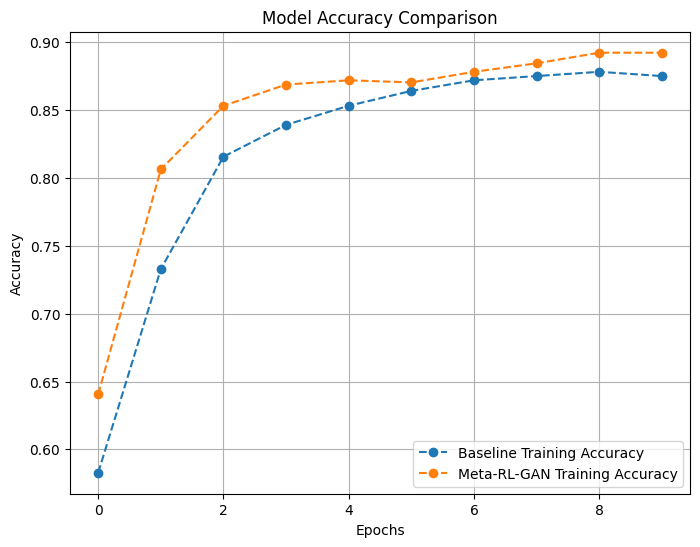

In [ ]:
# Plot accuracy comparison
plt.figure(figsize=(8, 6))
plt.plot(baseline_history.history['accuracy'], label='Baseline Training Accuracy', linestyle='--', marker='o')
plt.plot(meta_gan_history.history['accuracy'], label='Meta-GAN Training Accuracy', linestyle='--', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.legend()
plt.grid(True)
plt.show()